In [43]:
# Importing libraries
import re
import pandas as pd
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud
from collections import Counter
import string
import warnings
warnings.filterwarnings('ignore')

In [44]:
# Setting display options
pd.set_option('display.max_columns', None)
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

# Storing the file path
csv_file_path = 'C:/Users/DELL/Desktop/Datasets/twitter_tweets.csv'

# Loading the dataset
try:
    df = pd.read_csv(csv_file_path, 
                    encoding='latin-1', 
                    names=['sentiment', 'id', 'date', 'query', 'user', 'text'])
    
    # Converting original sentiment labels (0, 4) to positive/negative
    df['sentiment'] = df['sentiment'].map({0: 'negative', 4: 'positive'})
    
    print(f"Dataset loaded successfully with {len(df):,} tweets")
except Exception as e:
    print(f"Error loading dataset: {str(e)}")
    exit()

Dataset loaded successfully with 1,600,000 tweets


In [45]:
# Getting basic statistics about the dataset
print(f"Total tweets: {len(df):,}")

Total tweets: 1,600,000


In [46]:
# Getting Sentiment distribution
sentiment_counts = df['sentiment'].value_counts()
print("Sentiment distribution:")
for sentiment, count in sentiment_counts.items():
    print(f"  - {sentiment}: {count:,} ({count/len(df):.2%})")

Sentiment distribution:
  - negative: 800,000 (50.00%)
  - positive: 800,000 (50.00%)


In [47]:
# Checking for missing values
missing_values = df.isnull().sum()
if missing_values.sum() > 0:
    print("Missing values:")
    print(missing_values[missing_values > 0])
else:
    print("No missing values found.")

No missing values found.


In [48]:
# Displaying some sample tweets
print("\nSample tweets:")
for sentiment in df['sentiment'].unique():
    sample = df[df['sentiment'] == sentiment].sample(1).iloc[0]
    print(f"  [{sentiment}] {sample['text']}")


Sample tweets:
  [negative] I just told the people that matters the most to me to just leave me alone... I fucked up again. 
  [positive] I think you are super cute...  


In [49]:
# Preprocessing the text data (using a sample for faster processing)
print("\n===== Preprocessing Tweets =====")

# Using a sample for faster processing
sample_size = 10000
print(f"Using a random sample of {sample_size:,} tweets for analysis")
processed_data = df.sample(sample_size, random_state=42)

print("Cleaning tweets...")

# Defining clean_tweet function
def clean_tweet(tweet):
    """Clean tweet text by removing links, special characters using regex"""
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\\w+:\\/\\/\\S+)", " ", tweet).split())

# Cleaning tweets
processed_data['clean_text'] = processed_data['text'].apply(clean_tweet)

# Calculating tweet length
processed_data['tweet_length'] = processed_data['clean_text'].apply(len)

# Extracting TextBlob sentiment features
print("Extracting sentiment features...")
processed_data['polarity'] = processed_data['clean_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
processed_data['subjectivity'] = processed_data['clean_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Compare TextBlob sentiment with dataset labels
processed_data['textblob_sentiment'] = processed_data['polarity'].apply(lambda x: 'positive' if x > 0 else 'negative')

# Calculate agreement between TextBlob and dataset labels
agreement = (processed_data['sentiment'] == processed_data['textblob_sentiment']).mean()
print(f"Agreement between TextBlob and dataset labels: {agreement:.2%}")


===== Preprocessing Tweets =====
Using a random sample of 10,000 tweets for analysis
Cleaning tweets...
Extracting sentiment features...
Agreement between TextBlob and dataset labels: 62.44%


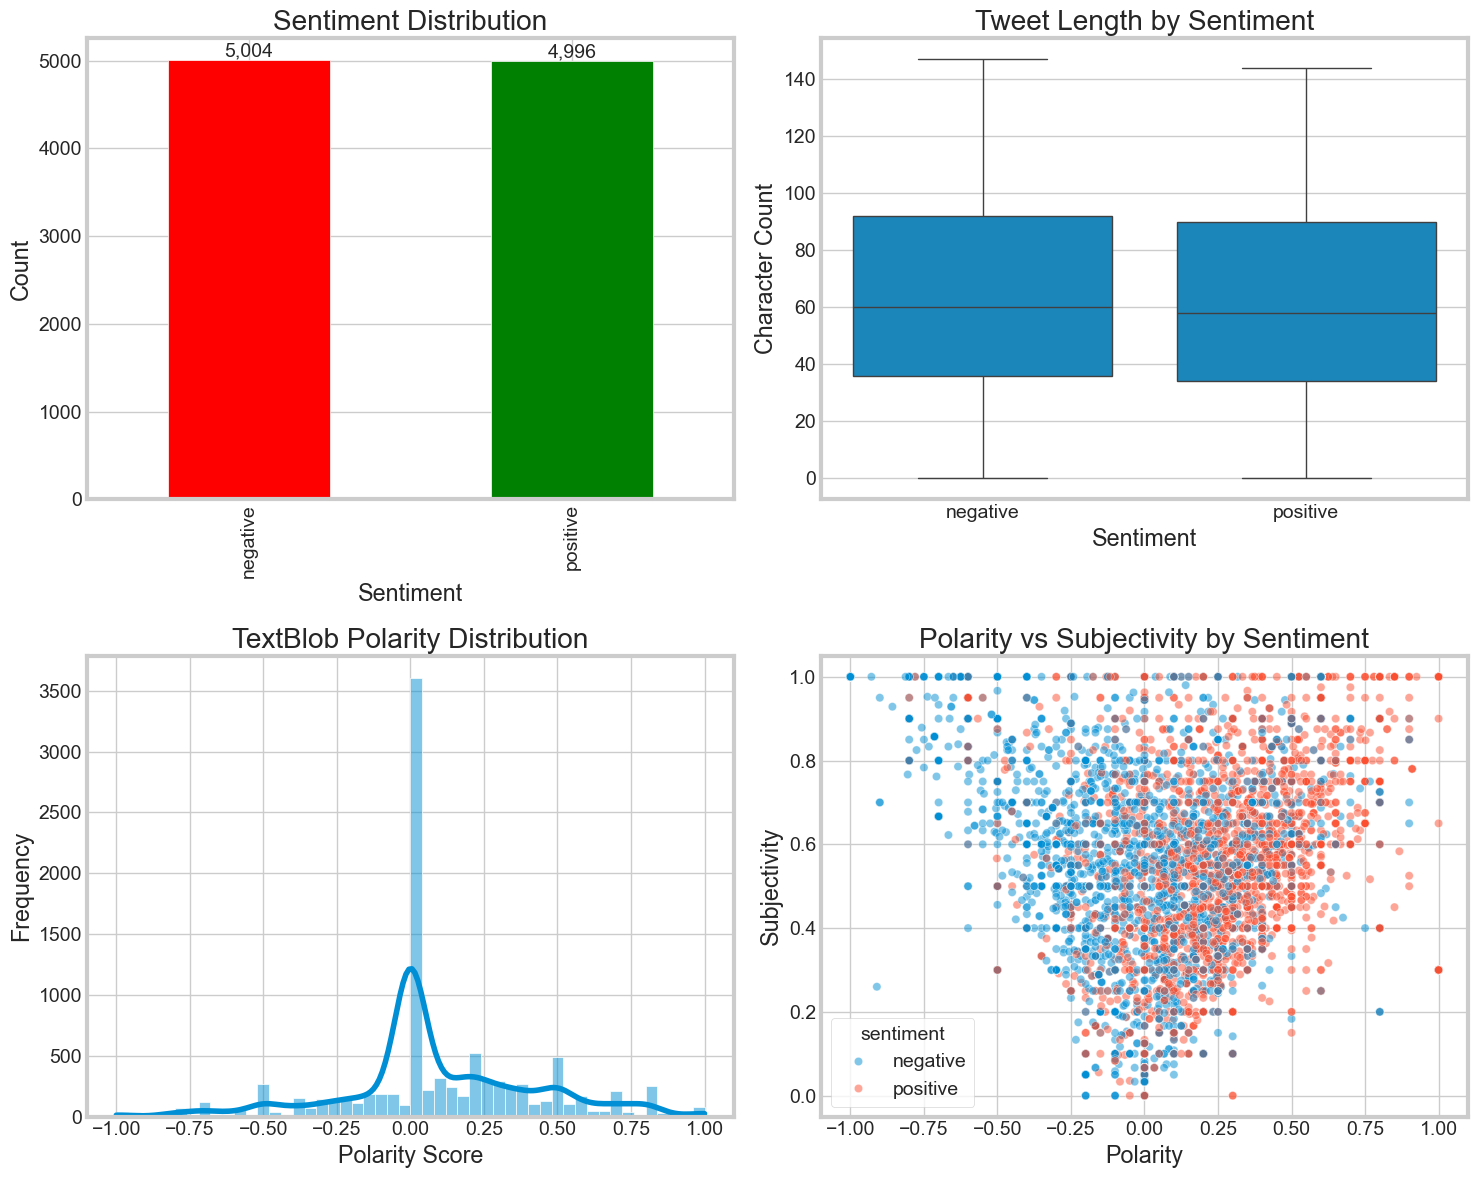

In [50]:
# Visualizing the data

# Creating a figure for various plots
plt.figure(figsize=(15, 12))

# Plot 1: Sentiment distribution
plt.subplot(2, 2, 1)
ax = processed_data['sentiment'].value_counts().plot(kind='bar', color=['red', 'green'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Adding count labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():,}', 
              (p.get_x() + p.get_width()/2, p.get_height()), 
              ha='center', va='bottom')

# Plot 2: Tweet length distribution by sentiment
plt.subplot(2, 2, 2)
sns.boxplot(x='sentiment', y='tweet_length', data=processed_data)
plt.title('Tweet Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Character Count')

# Plot 3: TextBlob polarity distribution
plt.subplot(2, 2, 3)
sns.histplot(processed_data['polarity'], bins=50, kde=True)
plt.title('TextBlob Polarity Distribution')
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')

# Plot 4: TextBlob subjectivity vs polarity
plt.subplot(2, 2, 4)
sns.scatterplot(x='polarity', y='subjectivity', hue='sentiment', data=processed_data, alpha=0.5)
plt.title('Polarity vs Subjectivity by Sentiment')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')

plt.tight_layout()
plt.show()

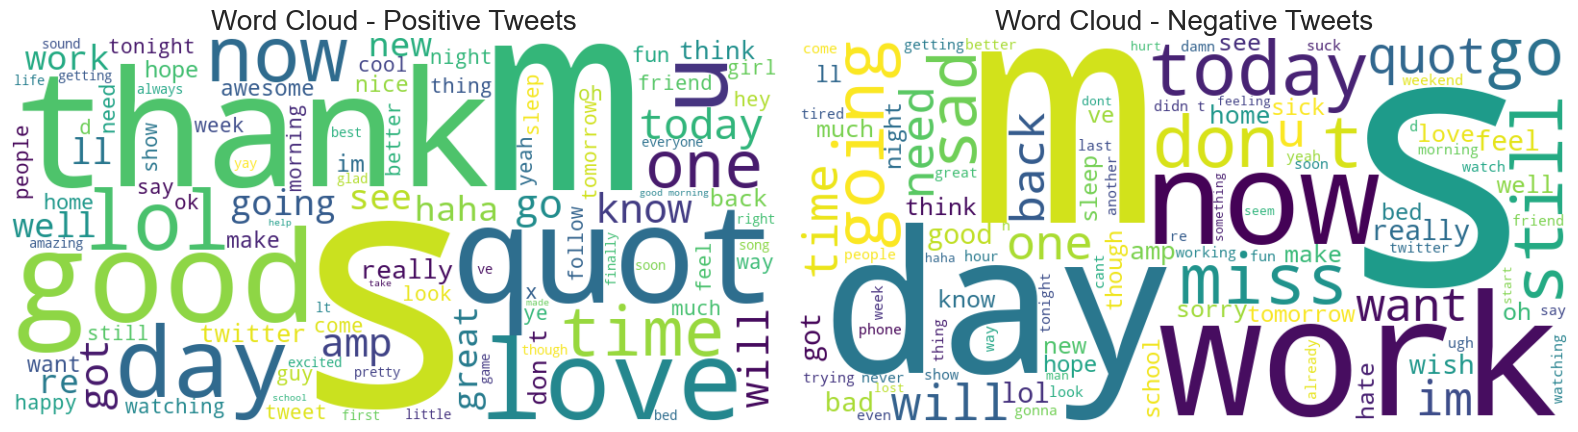

In [51]:
# Creating word clouds

# Preprocessing text for word cloud
processed_data['processed_text'] = processed_data['clean_text'].apply(lambda text: 
    re.sub(r'\s+', ' ', 
        re.sub(r'\d+', '', 
            text.lower().translate(str.maketrans('', '', string.punctuation))
        )
    ).strip()
)

# Creating word clouds for each sentiment
plt.figure(figsize=(16, 8))

for i, sentiment in enumerate(['positive', 'negative']):
    plt.subplot(1, 2, i+1)
    
    # Combining all tweets of this sentiment
    text = ' '.join(processed_data[processed_data['sentiment'] == sentiment]['processed_text'])
    
    # Generating word cloud
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        max_words=100,
        background_color='white',
        colormap='viridis',
        contour_width=1,
        contour_color='steelblue'
    ).generate(text)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud - {sentiment.capitalize()} Tweets')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [52]:
# Analyzing common words

# Defining stopwords (simplified approach)
stopwords = ['the', 'to', 'and', 'a', 'in', 'is', 'it', 'you', 'that', 'of', 
            'for', 'on', 'at', 'with', 'this', 'my', 'i', 'me', 'was', 'be', 'as']

# Function to get word frequencies
def get_word_freq(texts):
    words = ' '.join(texts).lower().split()
    words = [word for word in words if word not in stopwords and len(word) > 2]
    return Counter(words)

# Getting top N words for visualization
top_n = 20

# Getting word frequencies for each sentiment
pos_freq = get_word_freq(processed_data[processed_data['sentiment'] == 'positive']['clean_text'])
neg_freq = get_word_freq(processed_data[processed_data['sentiment'] == 'negative']['clean_text'])

# Getting most common words
pos_common = pos_freq.most_common(top_n)
neg_common = neg_freq.most_common(top_n)

# Printing the common words
print(f"\nTop {top_n} words in positive tweets:")
for word, count in pos_common:
    print(f"  - {word}: {count}")

print(f"\nTop {top_n} words in negative tweets:")
for word, count in neg_common:
    print(f"  - {word}: {count}")


Top 20 words in positive tweets:
  - good: 421
  - have: 408
  - just: 393
  - quot: 300
  - but: 298
  - your: 284
  - are: 284
  - day: 280
  - love: 280
  - all: 277
  - can: 274
  - lol: 245
  - out: 243
  - now: 239
  - like: 236
  - get: 230
  - thanks: 230
  - not: 217
  - time: 202
  - got: 194

Top 20 words in negative tweets:
  - but: 540
  - not: 476
  - have: 469
  - just: 374
  - can: 320
  - now: 304
  - get: 300
  - work: 270
  - out: 262
  - like: 249
  - today: 241
  - going: 237
  - day: 234
  - all: 232
  - don: 225
  - are: 220
  - still: 215
  - miss: 213
  - too: 207
  - back: 204


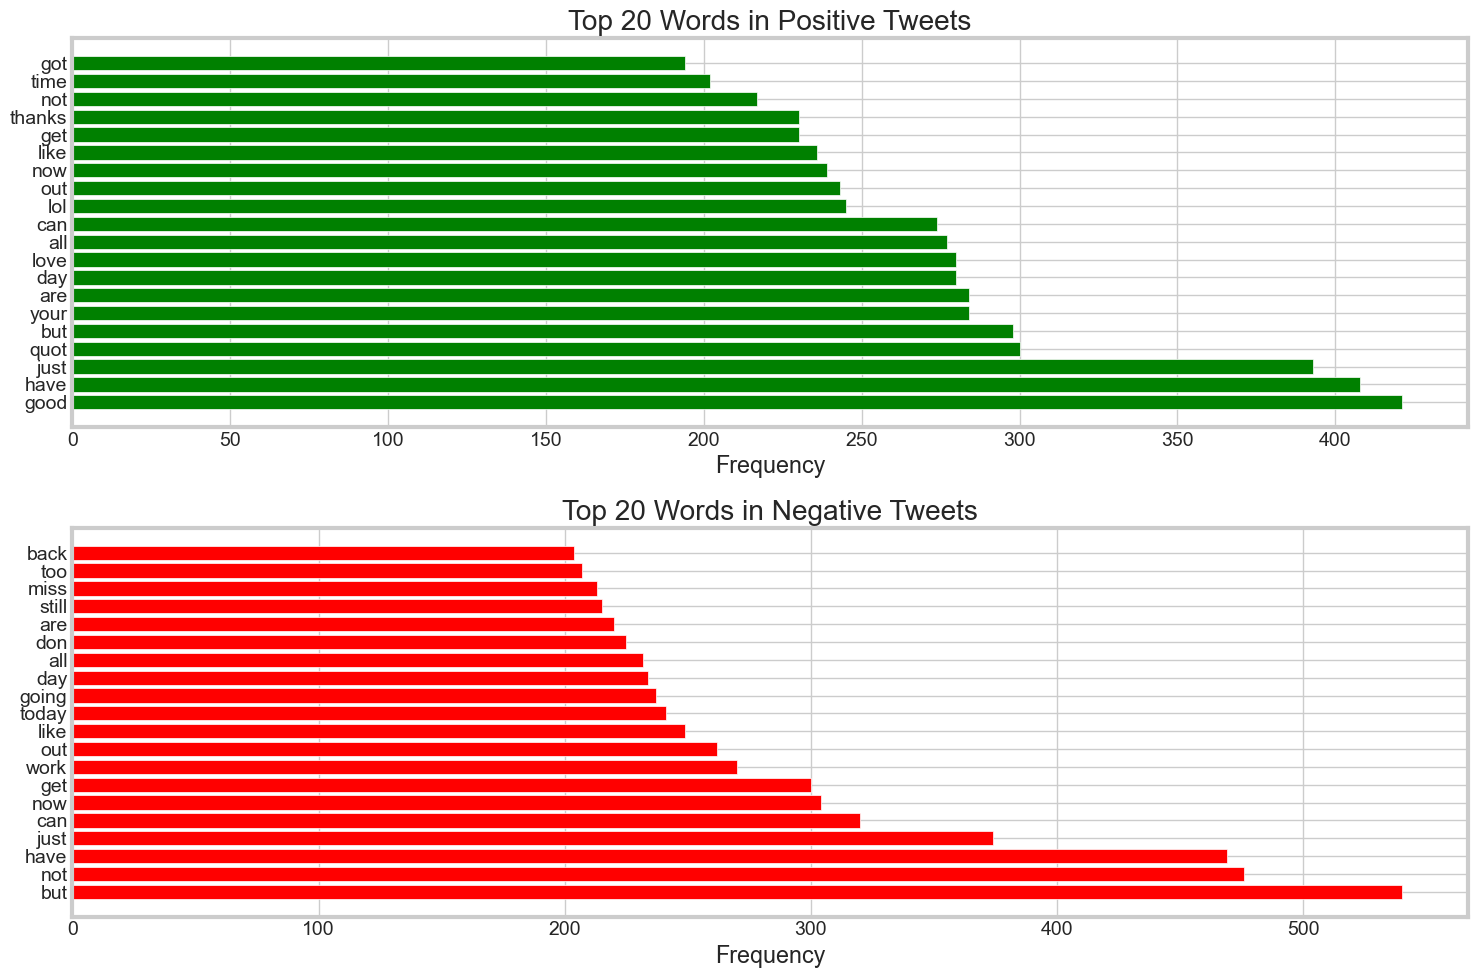

In [53]:
# Plot most common words
plt.figure(figsize=(15, 10))

# Plot common positive words
plt.subplot(2, 1, 1)
words, counts = zip(*pos_common)
plt.barh(range(len(words)), counts, color='green')
plt.yticks(range(len(words)), words)
plt.title(f'Top {top_n} Words in Positive Tweets')
plt.xlabel('Frequency')

# Plot common negative words
plt.subplot(2, 1, 2)
words, counts = zip(*neg_common)
plt.barh(range(len(words)), counts, color='red')
plt.yticks(range(len(words)), words)
plt.title(f'Top {top_n} Words in Negative Tweets')
plt.xlabel('Frequency')

plt.tight_layout()
plt.show()

In [54]:
# Step 7: Search for tweets about specific topics
print("\n===== Sample Tweets About Specific Topics =====")
topics = ['apple', 'google', 'twitter', 'love', 'hate']

for topic in topics:
    print(f"\nSample tweets about '{topic}':")
    # Search for tweets containing the topic (case insensitive)
    topic_tweets = df[df['text'].str.contains(topic, case=False, regex=False)].head(3)
    
    if len(topic_tweets) == 0:
        print(f"No tweets found containing '{topic}'")
    else:
        for i, (_, tweet) in enumerate(topic_tweets.iterrows()):
            sentiment = tweet['sentiment']
            text = tweet['text']
            print(f"{i+1}. [{sentiment}] {text}")


===== Sample Tweets About Specific Topics =====

Sample tweets about 'apple':
1. [negative] @treesahquiche okay, about the applepears, I've talked to a few people and they've ALL had them before. No one ever told me, never 
2. [negative] Nasty budget due and my iphone is being sent to Apple today. 
3. [negative] Just woke up. Apples gig was ace last night. Seriously tired now. Work begins in one hour... 

Sample tweets about 'google':
1. [negative] I accessed oneindia.mobi from a Google phone (Android). It doesn't support Indic languages 
2. [negative] and they advertising fake louis bags as 100% authentic on google  i'm pissed!
3. [negative] Ads not yet appeared  Google Adsense Team said it may delay 48 hrs on http://womenissues.info

Sample tweets about 'twitter':
1. [negative] @twittera que me muera ? 
2. [negative] I miss you twitter. My phone broke, now I'm using a stupid Nokia phone. Ughhh, I miss my advance phone. 
3. [negative] @charlietm I know right. I dunno what is going on

In [55]:
# Step 8: Prepare data for modeling
print("\n===== Preparing Data for Modeling =====")

# Use a sample for modeling
model_sample_size = 20000
print(f"Using a random sample of {model_sample_size:,} tweets for modeling")
model_data = df.sample(model_sample_size, random_state=42)

# Features and target
X = model_data['text']
y = model_data['sentiment']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train):,}")
print(f"Test set size: {len(X_test):,}")


===== Preparing Data for Modeling =====
Using a random sample of 20,000 tweets for modeling
Training set size: 16,000
Test set size: 4,000


In [56]:
# Step 9: Build and evaluate Logistic Regression model
print("\n===== Building Logistic Regression Model =====")

# Create pipeline with TF-IDF vectorizer and Logistic Regression
lr_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Train the model
print("Training Logistic Regression model...")
lr_pipeline.fit(X_train, y_train)

# Make predictions
lr_pred = lr_pipeline.predict(X_test)

# Get prediction probabilities for ROC curve
lr_prob = lr_pipeline.predict_proba(X_test)
# Get the index of the positive class
lr_positive_idx = list(lr_pipeline.classes_).index('positive')
lr_prob_pos = lr_prob[:, lr_positive_idx]

# Evaluate
lr_accuracy = accuracy_score(y_test, lr_pred)
lr_report = classification_report(y_test, lr_pred)
lr_cm = confusion_matrix(y_test, lr_pred)

# ROC curve
lr_fpr, lr_tpr, _ = roc_curve(y_test == 'positive', lr_prob_pos)
lr_auc = auc(lr_fpr, lr_tpr)

# Print results
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")
print("Classification Report:")
print(lr_report)


===== Building Logistic Regression Model =====
Training Logistic Regression model...
Logistic Regression Accuracy: 0.7668
Classification Report:
              precision    recall  f1-score   support

    negative       0.77      0.76      0.76      1988
    positive       0.77      0.77      0.77      2012

    accuracy                           0.77      4000
   macro avg       0.77      0.77      0.77      4000
weighted avg       0.77      0.77      0.77      4000



In [57]:
# Step 10: Build and evaluate Naive Bayes model
print("\n===== Building Naive Bayes Model =====")

# Create pipeline with Count vectorizer and Multinomial Naive Bayes
nb_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(max_features=10000, ngram_range=(1, 2))),
    ('classifier', MultinomialNB())
])

# Train the model
print("Training Naive Bayes model...")
nb_pipeline.fit(X_train, y_train)

# Make predictions
nb_pred = nb_pipeline.predict(X_test)

# Get prediction probabilities for ROC curve
nb_prob = nb_pipeline.predict_proba(X_test)
# Get the index of the positive class
nb_positive_idx = list(nb_pipeline.classes_).index('positive')
nb_prob_pos = nb_prob[:, nb_positive_idx]

# Evaluate
nb_accuracy = accuracy_score(y_test, nb_pred)
nb_report = classification_report(y_test, nb_pred)
nb_cm = confusion_matrix(y_test, nb_pred)

# ROC curve
nb_fpr, nb_tpr, _ = roc_curve(y_test == 'positive', nb_prob_pos)
nb_auc = auc(nb_fpr, nb_tpr)

# Print results
print(f"Naive Bayes Accuracy: {nb_accuracy:.4f}")
print("Classification Report:")
print(nb_report)


===== Building Naive Bayes Model =====
Training Naive Bayes model...
Naive Bayes Accuracy: 0.7580
Classification Report:
              precision    recall  f1-score   support

    negative       0.75      0.77      0.76      1988
    positive       0.77      0.75      0.76      2012

    accuracy                           0.76      4000
   macro avg       0.76      0.76      0.76      4000
weighted avg       0.76      0.76      0.76      4000



In [58]:
# Step 11: Compare models
print("\n===== Comparing Models =====")

# Create a dataframe for comparison
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Naive Bayes'],
    'Accuracy': [lr_accuracy, nb_accuracy],
    'AUC': [lr_auc, nb_auc]
})

print("Model comparison:")
print(comparison_df)


===== Comparing Models =====
Model comparison:
                 Model  Accuracy       AUC
0  Logistic Regression   0.76675  0.846830
1          Naive Bayes   0.75800  0.824038


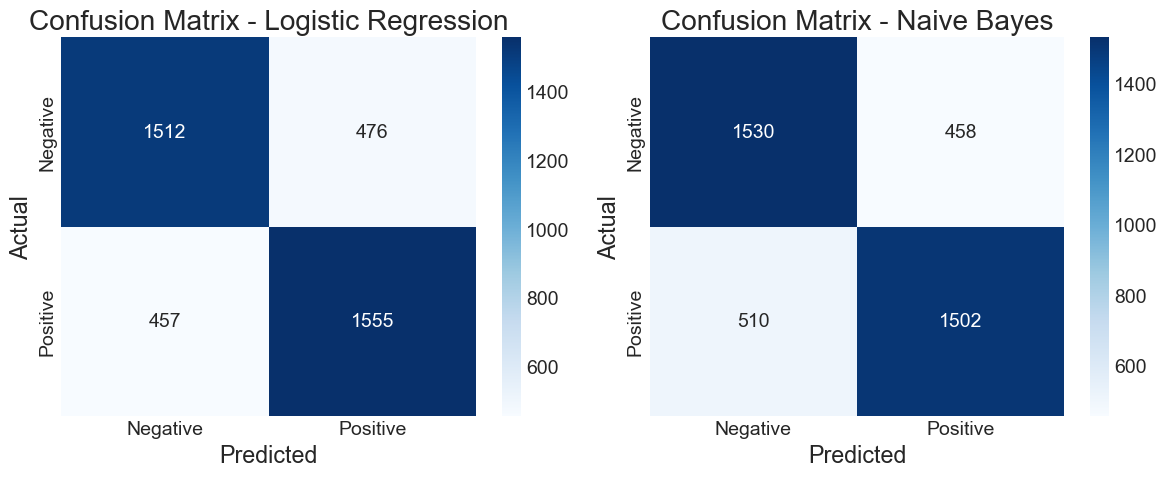

In [59]:
# Plot confusion matrices
plt.figure(figsize=(12, 5))

# Logistic Regression confusion matrix
plt.subplot(1, 2, 1)
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Negative', 'Positive'],
           yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Naive Bayes confusion matrix
plt.subplot(1, 2, 2)
sns.heatmap(nb_cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Negative', 'Positive'],
           yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Naive Bayes')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

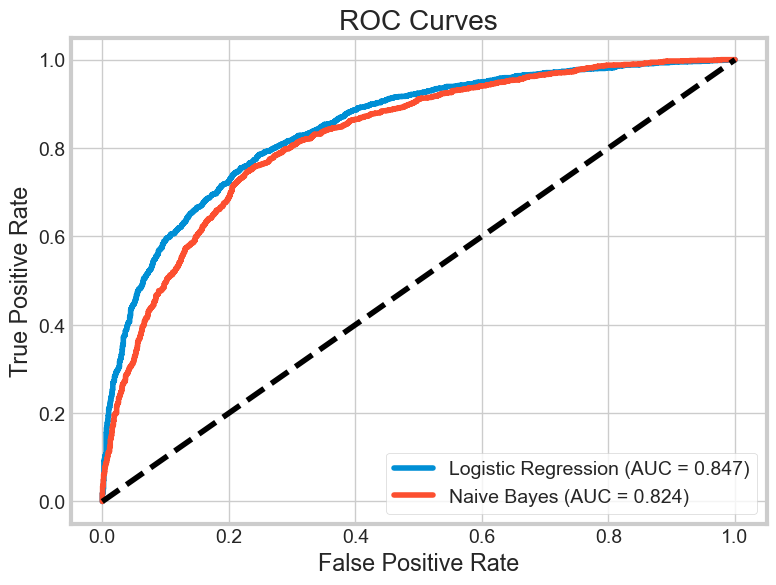

In [60]:
# Plot ROC curves
plt.figure(figsize=(8, 6))

# Logistic Regression ROC curve
plt.plot(lr_fpr, lr_tpr, 
         label=f'Logistic Regression (AUC = {lr_auc:.3f})')

# Naive Bayes ROC curve
plt.plot(nb_fpr, nb_tpr, 
         label=f'Naive Bayes (AUC = {nb_auc:.3f})')

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()

In [61]:
# Determine the better model
if lr_accuracy > nb_accuracy:
    better_model_name = 'Logistic Regression'
    better_model_pipeline = lr_pipeline
    better_model_accuracy = lr_accuracy
else:
    better_model_name = 'Naive Bayes'
    better_model_pipeline = nb_pipeline
    better_model_accuracy = nb_accuracy

print(f"\nBest performing model: {better_model_name} (Accuracy: {better_model_accuracy:.4f})")

# Calculate difference in performance
models_diff = abs(lr_accuracy - nb_accuracy)
if models_diff < 0.02:  # Less than 2% difference
    print("Both models perform similarly in terms of accuracy.")
else:
    print(f"The {better_model_name} model outperforms the other model by {models_diff:.2%} in accuracy.")

# Add recommendations based on model characteristics
print("\nModel Characteristics:")
print("- Logistic Regression tends to perform well with large datasets and provides interpretable coefficients.")
print("- Naive Bayes is computationally efficient and works well with high-dimensional feature spaces.")



Best performing model: Logistic Regression (Accuracy: 0.7668)
Both models perform similarly in terms of accuracy.

Model Characteristics:
- Logistic Regression tends to perform well with large datasets and provides interpretable coefficients.
- Naive Bayes is computationally efficient and works well with high-dimensional feature spaces.


In [62]:
# Step 12: Make predictions with the best model on new tweets
print("\n===== Making Predictions with Best Model =====")

new_tweets = [
    "I absolutely love this new phone! It's amazing!",
    "This movie was terrible, waste of money.",
    "The service at this restaurant was okay, but the food was great.",
    "I'm not sure how I feel about the new policy changes.",
    "Can't wait for the weekend to start!"
]

# Make predictions
predictions = better_model_pipeline.predict(new_tweets)

# Get prediction probabilities
proba = better_model_pipeline.predict_proba(new_tweets)
# Get the index of the positive class
positive_idx = list(better_model_pipeline.classes_).index('positive')

# Print results with confidence
for i, (tweet, pred) in enumerate(zip(new_tweets, predictions)):
    confidence = proba[i][positive_idx] if pred == 'positive' else 1 - proba[i][positive_idx]
    print(f"Tweet: {tweet}")
    print(f"Prediction: {pred} (confidence: {confidence:.2f})")
    print("---")

print("\n===== Analysis Complete =====")
print("You can use the trained model for sentiment analysis on new tweets.")


===== Making Predictions with Best Model =====
Tweet: I absolutely love this new phone! It's amazing!
Prediction: positive (confidence: 0.83)
---
Tweet: This movie was terrible, waste of money.
Prediction: positive (confidence: 0.51)
---
Tweet: The service at this restaurant was okay, but the food was great.
Prediction: positive (confidence: 0.69)
---
Tweet: I'm not sure how I feel about the new policy changes.
Prediction: negative (confidence: 0.61)
---
Tweet: Can't wait for the weekend to start!
Prediction: positive (confidence: 0.65)
---

===== Analysis Complete =====
You can use the trained model for sentiment analysis on new tweets.
